# Get Paper Stats

In [1]:
import pandas as pd
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np

In [2]:
# Import Processed Indication Files
indications = pd.read_csv(
    "/home/rogertu/projects/semmed/semmed/data/time_networks-6_metanode/2021/indications.csv"
)
# Import Raw Indication Files from DC
og = pd.read_csv(
    "/home/rogertu/projects/semmed/semmed/data/drugcentral_rel_20211005.csv"
)

## Raw indication file stats

In [3]:
print(f"Size of Raw: {og.shape}")

Size of Raw: (41430, 9)


In [4]:
og.head(2)

,id,struct_id,concept_id,relationship_name,concept_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid
0,174026,5391,40249429,indication,Triple negative breast neoplasms,C3539878,Triple negative breast neoplasms,T191,706970001.0
1,174027,5392,40249397,indication,Metastatic non-small cell lung cancer,C0278987,Metastatic non-small cell lung cancer,T191,NaN


In [5]:
indications.shape

(5971, 16)

In [6]:
# Unique relationships in Raw
set(og.relationship_name)

{'contraindication',
 'diagnosis',
 'indication',
 'off-label use',
 'reduce risk',
 'symptomatic treatment'}

In [7]:
# How many are indications?
og.query('relationship_name=="indication"').shape

(11292, 9)

In [8]:
# How many are indications AND have a umls_cui?
og.query('relationship_name=="indication" & umls_cui==umls_cui').shape

(8806, 9)

In [9]:
# How many unique umls_cui's given its an indication?
len(set(og.query('relationship_name=="indication" & umls_cui==umls_cui').umls_cui))

1459

In [10]:
# How many unique structure ids (compounds) given indication and indication has a umls cui?
len(set(og.query('relationship_name=="indication" & umls_cui==umls_cui').struct_id))

2494

In [11]:
# How many unique concept ids (compounds) given indication and indication has a umls cui?
len(set(og.query('relationship_name=="indication" & umls_cui==umls_cui').concept_id))

1479

## Processed indication file stats

In [12]:
indications.head(2)

,id,struct_id,concept_id,relationship_name,disease_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid,compound_name,compound_semmed_id,disease_semmed_id,approval_date,approval_year,year_diff,year_cat
0,174026,5391,40249429,indication,Triple negative breast neoplasms,C3539878,Triple negative breast neoplasms,T191,706970001.0,sacituzumab govitecan,C000608132,D064726,2020-04-04,2020,-1,0-5 Before
1,174027,5392,40249397,indication,Metastatic non-small cell lung cancer,C0278987,Metastatic non-small cell lung cancer,T191,NaN,capmatinib,C000613976,C0278987,2020-05-06,2020,-1,0-5 Before


In [13]:
# Size of indications
indications.shape

(5971, 16)

In [14]:
print(
    f"Unique compounds in processed indications: {len(set(indications.compound_semmed_id))}"
)
print(f"Unique umls ids in processed indications: {len(set(indications.umls_cui))}")
print(
    f"Unique diseases in processed indications: {len(set(indications.disease_semmed_id))}"
)

Unique compounds in processed indications: 1750
Unique umls ids in processed indications: 1118
Unique diseases in processed indications: 882


## Mapped, processed indication file stats

In [15]:
# Import Test and Valid
test = pd.read_csv("./data/MIND_CtD_Slice0/test.txt", names=["h", "r", "t"], sep="\t")
valid = pd.read_csv("./data/MIND_CtD_Slice0/valid.txt", names=["h", "r", "t"], sep="\t")
train = pd.read_csv(
    "./data/MIND_CtD_Slice0/train.txt",
    names=[
        "h",
        "r",
        "t",
    ],
    sep="\t",
)

In [16]:
print(f"Test Size: {test.shape}")
print(f"Valid Size: {valid.shape}")
print(f"Unique Drugs in Test: {len(set(test.h))}")
print(f"Unique Drugs in Valid: {len(set(valid.h))}")
print(f"Unique Disease in Test: {len(set(test.t))}")
print(f"Unique Disease in Valid: {len(set(valid.t))}")

Test Size: (538, 3)
Valid Size: (538, 3)
Unique Drugs in Test: 82
Unique Drugs in Valid: 112
Unique Disease in Test: 287
Unique Disease in Valid: 306


### Concatenate indications by pulling from split files

In [17]:
train.head(2)

,h,r,t
0,UNII:BTY153760O,inhibits_CinG,NCBIGene:3605
1,CHEBI:10056,activates_CaG,NCBIGene:1129


In [18]:
# extract out relations without Meta information
train["short_r"] = train.r.apply(lambda x: re.match("^[a-z]+", x)[0])

In [19]:
train.query('short_r=="indication"').head(2)

,h,r,t,short_r
9646737,CHEBI:31456,indication,DOID:8761,indication
9646738,CHEBI:31456,indication,DOID:8864,indication


In [20]:
inds = pd.concat([train.query('short_r=="indication"'), test, valid])
inds = inds[["h", "r", "t"]]

In [21]:
print(f"Size of matched indications: {inds.shape[0]:,}")
print(f"Number of Unique Drugs: {len(set(inds.h)):,}")
print(f"Number of Unique Diseases: {len(set(inds.t)):,}")

print(f"Size of Train file: {train.shape[0]:,}")
print(
    f'Size of Train less indications: {train.shape[0]-train[train["short_r"]=="indication"].shape[0]:,}'
)

Size of matched indications: 5,379
Number of Unique Drugs: 1,308
Number of Unique Diseases: 1,030
Size of Train file: 9,651,040
Size of Train less indications: 9,646,737


## Generate a 2 heatmaps, Metanode-Metanode Counts & Metanode-Relation Counts
* Also get stats on each metanode and relation

### Get stats on each metanode

In [22]:
# count of each metanode
graph = pd.concat([train, test, valid])

In [23]:
graph.head(2)

,h,r,t,short_r
0,UNII:BTY153760O,inhibits_CinG,NCBIGene:3605,inhibits
1,CHEBI:10056,activates_CaG,NCBIGene:1129,activates


In [24]:
graph['r'] = graph.r.apply(lambda x: re.sub('>','',x))

In [25]:
# first gotta get the type for indication
subgraph1 = graph.query('r=="indication"')
subgraph2 = graph.query('r!="indication"')

nodes = pd.read_csv("../../MRN_dataset/nodes_biolink.csv")
nodes.head(2)

/tmp/ipykernel_2765190/2407832694.py:5: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes = pd.read_csv("../../MRN_dataset/nodes_biolink.csv")


,id,name,label,xrefs,source,synonyms,alt_ids,subsets
0,UBERON:0000002,cervix,AnatomicalEntity,MESH:D002584|UBERON:0000002,NaN,NaN,NaN,NaN
1,UBERON:0000004,human nose,AnatomicalEntity,MESH:D009666|UBERON:0000004,NaN,NaN,NaN,NaN


In [26]:
# do a double merge to  get h and t labels
subgraph1 = pd.merge(
    left=pd.merge(
        left=subgraph1,
        right=nodes[["id", "label"]],
        how="left",
        left_on="h",
        right_on="id",
    )[["h", "r", "t", "short_r", "label"]].rename(columns={"label": "h_type"}),
    right=nodes[["id", "label"]],
    how="left",
    left_on="t",
    right_on="id",
)[["h", "r", "t", "short_r", "h_type", "label"]].rename(columns={"label": "t_type"})

subgraph1.head(2)

,h,r,t,short_r,h_type,t_type
0,CHEBI:31456,indication,DOID:8761,indication,ChemicalSubstance,Disease
1,CHEBI:31456,indication,DOID:8864,indication,ChemicalSubstance,Disease


In [27]:
set(subgraph1.h_type)

{'AnatomicalEntity', 'ChemicalSubstance', 'MacromolecularMachine'}

In [28]:
set(subgraph1.t_type)

{'Disease', 'MacromolecularMachine', 'Pathway', 'PhenotypicFeature'}

In [29]:
mapper_dict= {'AnatomicalEntity':'A', 'ChemicalSubstance':'C', 'MacromolecularMachine':'G','Disease':'D', 'Pathway':'PW', 'PhenotypicFeature':'P'}

In [30]:
subgraph1['h_type'] = subgraph1.h_type.apply(lambda x: mapper_dict[x])
subgraph1['t_type'] = subgraph1.t_type.apply(lambda x: mapper_dict[x])
subgraph1['r_type'] = 'indication'

In [31]:
# extract out the metapath
subgraph2["h_type"] = subgraph2.r.apply(lambda x: re.findall("[A-Z]+", x)[0])
subgraph2["t_type"] = subgraph2.r.apply(lambda x: re.findall("[A-Z]+", x)[1])
subgraph2["r_type"] = subgraph2.r.apply(lambda x: re.findall("[^A-Z]+", x)[0][:-1])

/tmp/ipykernel_2765190/2103888270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph2["h_type"] = subgraph2.r.apply(lambda x: re.findall("[A-Z]+", x)[0])
/tmp/ipykernel_2765190/2103888270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph2["t_type"] = subgraph2.r.apply(lambda x: re.findall("[A-Z]+", x)[1])
/tmp/ipykernel_2765190/2103888270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [32]:
graph = pd.concat([subgraph2,subgraph1])
graph.shape

(9652116, 7)

In [71]:
# look for BP
graph.head(2)

,h,r,t,short_r,h_type,t_type,r_type
0,UNII:BTY153760O,inhibits_CinG,NCBIGene:3605,inhibits,"Chemical\nSubstance\n(40,455)","Macromolecular\nMachine\n(136,991)","inhibits\n(456,672)"
1,CHEBI:10056,activates_CaG,NCBIGene:1129,activates,"Chemical\nSubstance\n(40,455)","Macromolecular\nMachine\n(136,991)","activates\n(511,879)"


In [72]:
set(graph.h_type)

{'Anatomical\nEntity\n(3,498)',
 'Biological\nProcess\n(21,057)',
 'Chemical\nSubstance\n(40,455)',
 'Disease\n(13,942)',
 'Gene\nFamily\n(10,797)',
 'Macromolecular\nMachine\n(136,991)',
 'Pathway\n(5,363)',
 'Taxon\n(12,074)'}

In [79]:
graph[graph['h_type']=='Biological\nProcess\n(21,057)'].groupby('t_type').count()

,h,r,t,short_r,h_type,r_type
t_type,,,,,,
"Anatomical\nEntity\n(3,498)",1008,1008,1008,1008,1008,1008
"Disease\n(13,942)",2052856,2052856,2052856,2052856,2052856,2052856
"Phenotypic\nFeature\n(5,428)",525176,525176,525176,525176,525176,525176
"Taxon\n(12,074)",646449,646449,646449,646449,646449,646449


In [33]:
node_count_df = (
    pd.concat(
        [
            graph[["h", "h_type"]].rename(columns={"h": "node", "h_type": "type"}),
            graph[["t", "t_type"]].rename(columns={"t": "node", "t_type": "type"}),
        ]
    )
    .drop_duplicates()
    .groupby("type")
    .count()
    .reset_index()
)

node_count_df

,type,node
0,A,3498
1,BP,21057
2,C,40455
3,D,13942
4,F,10797
5,G,136991
6,P,5428
7,PW,5363
8,T,12074


In [34]:
node_dict = {
    "A": "Anatomical\nEntity",
    "BP": "Biological\nProcess",
    "C": "Chemical\nSubstance",
    "D": "Disease",
    "F": "Gene\nFamily",
    "G": "Macromolecular\nMachine",
    "P": "Phenotypic\nFeature",
    "PW": "Pathway",
    "T": "Taxon",
}

In [35]:
for i, v in enumerate(node_count_df["type"]):
    print(f"Metanode: '{node_dict[v]}' has count {node_count_df['node'][i]:,}")

Metanode: 'Anatomical
Entity' has count 3,498
Metanode: 'Biological
Process' has count 21,057
Metanode: 'Chemical
Substance' has count 40,455
Metanode: 'Disease' has count 13,942
Metanode: 'Gene
Family' has count 10,797
Metanode: 'Macromolecular
Machine' has count 136,991
Metanode: 'Phenotypic
Feature' has count 5,428
Metanode: 'Pathway' has count 5,363
Metanode: 'Taxon' has count 12,074


### relation counts

In [36]:
r_count_dict = dict(
    zip(
        graph.groupby("r_type").count().reset_index()["r_type"],
        graph.groupby("r_type").count().reset_index()["r"],
    )
)
for i in r_count_dict.keys():
    print(f"Relation: {i} has count {r_count_dict[i]:,}")

Relation: activates has count 511,879
Relation: affects has count 986,831
Relation: associated_with has count 4,488,155
Relation: capable_of has count 513
Relation: causes has count 69,058
Relation: disrupts has count 541
Relation: has_input has count 10,905
Relation: in_reaction_with has count 152,741
Relation: in_taxon has count 1,208,845
Relation: indication has count 5,379
Relation: inhibits has count 456,672
Relation: marker_or_mechanism has count 64,272
Relation: negatively_regulates has count 21,439
Relation: palliates has count 2,282
Relation: part_of has count 1,252,342
Relation: positively_regulates has count 32,319
Relation: presents has count 66,965
Relation: prevents has count 1,280
Relation: produces has count 1,008
Relation: regulates has count 215,855
Relation: site_of has count 31,790
Relation: treats has count 71,045


### Generate heat maps

#### Node Node Heatmap

In [37]:
graph.groupby(["h_type", "t_type"]).count().reset_index()[["h_type", "t_type", "h"]]

,h_type,t_type,h
0,A,A,499
1,A,BP,711
2,A,D,171448
3,A,P,23176
4,A,PW,2610
5,A,T,412283
6,BP,A,1008
7,BP,D,2052856
8,BP,P,525176
9,BP,T,646449


In [38]:
nodes_count_dict = dict(
    zip(
        [v for i, v in enumerate(node_count_df["type"])],
        [f"{v:,}" for i, v in enumerate(node_count_df["node"])],
    )
)
nodes_count_dict

{'A': '3,498',
 'BP': '21,057',
 'C': '40,455',
 'D': '13,942',
 'F': '10,797',
 'G': '136,991',
 'P': '5,428',
 'PW': '5,363',
 'T': '12,074'}

In [39]:
graph["h_type"] = graph["h_type"].apply(
    lambda x: node_dict[x] + "\n" + f"({nodes_count_dict[x]})"
)
graph["t_type"] = graph["t_type"].apply(
    lambda x: node_dict[x] + "\n" + f"({nodes_count_dict[x]})"
)

In [40]:
graph["r_type"] = graph.r_type.apply(lambda x: x + "\n" + f"({r_count_dict[x]:,})")

In [41]:
nn_graph = (
    graph.groupby(["h_type", "t_type"])
    .count()
    .reset_index()[["h_type", "t_type", "h"]]
    .pivot(index="h_type", columns="t_type")
)
nn_graph = nn_graph["h"].reset_index()
nn_graph.columns.name = None

In [42]:
nn_graph

,h_type,"Anatomical\nEntity\n(3,498)","Biological\nProcess\n(21,057)","Chemical\nSubstance\n(40,455)","Disease\n(13,942)","Gene\nFamily\n(10,797)","Macromolecular\nMachine\n(136,991)","Pathway\n(5,363)","Phenotypic\nFeature\n(5,428)","Taxon\n(12,074)"
0,"Anatomical\nEntity\n(3,498)",499.0,711.0,NaN,171448.0,NaN,NaN,2610.0,23176.0,412283.0
1,"Biological\nProcess\n(21,057)",1008.0,NaN,NaN,2052856.0,NaN,NaN,NaN,525176.0,646449.0
2,"Chemical\nSubstance\n(40,455)",6092.0,190156.0,NaN,94205.0,NaN,1817397.0,1254170.0,8608.0,NaN
3,"Disease\n(13,942)",NaN,NaN,NaN,NaN,NaN,NaN,230.0,66965.0,NaN
4,"Gene\nFamily\n(10,797)",4830.0,21039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Macromolecular\nMachine\n(136,991)",272074.0,625267.0,164607.0,103958.0,26744.0,186201.0,265724.0,104614.0,158933.0
6,"Pathway\n(5,363)",NaN,2241.0,NaN,322195.0,NaN,NaN,311.0,48196.0,2085.0
7,"Taxon\n(12,074)",NaN,NaN,NaN,69058.0,NaN,NaN,NaN,NaN,NaN


In [43]:
nn_graph = nn_graph.set_index("h_type")
nn_graph

,"Anatomical\nEntity\n(3,498)","Biological\nProcess\n(21,057)","Chemical\nSubstance\n(40,455)","Disease\n(13,942)","Gene\nFamily\n(10,797)","Macromolecular\nMachine\n(136,991)","Pathway\n(5,363)","Phenotypic\nFeature\n(5,428)","Taxon\n(12,074)"
h_type,,,,,,,,,
"Anatomical\nEntity\n(3,498)",499.0,711.0,NaN,171448.0,NaN,NaN,2610.0,23176.0,412283.0
"Biological\nProcess\n(21,057)",1008.0,NaN,NaN,2052856.0,NaN,NaN,NaN,525176.0,646449.0
"Chemical\nSubstance\n(40,455)",6092.0,190156.0,NaN,94205.0,NaN,1817397.0,1254170.0,8608.0,NaN
"Disease\n(13,942)",NaN,NaN,NaN,NaN,NaN,NaN,230.0,66965.0,NaN
"Gene\nFamily\n(10,797)",4830.0,21039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Macromolecular\nMachine\n(136,991)",272074.0,625267.0,164607.0,103958.0,26744.0,186201.0,265724.0,104614.0,158933.0
"Pathway\n(5,363)",NaN,2241.0,NaN,322195.0,NaN,NaN,311.0,48196.0,2085.0
"Taxon\n(12,074)",NaN,NaN,NaN,69058.0,NaN,NaN,NaN,NaN,NaN


#### Node Relation Heatmap

In [44]:
hr_graph = (
    graph.groupby(["h_type", "r_type"]).count().reset_index()[["h_type", "r_type", "h"]]
)
tr_graph = (
    graph.groupby(["t_type", "r_type"]).count().reset_index()[["t_type", "r_type", "h"]]
)

hr_graph.head(2)

,h_type,r_type,h
0,"Anatomical\nEntity\n(3,498)","associated_with\n(4,488,155)",165641
1,"Anatomical\nEntity\n(3,498)",capable_of\n(513),513


In [45]:
tr_graph.head(2)

,t_type,r_type,h
0,"Anatomical\nEntity\n(3,498)","part_of\n(1,252,342)",283495
1,"Anatomical\nEntity\n(3,498)","produces\n(1,008)",1008


In [46]:
print(f"head-rel shape: {hr_graph.shape[0]}")
print(f"tail-rel shape: {tr_graph.shape[0]}")

head-rel shape: 42
tail-rel shape: 46


In [47]:
nr_graph = pd.merge(
    left=hr_graph,
    right=tr_graph.rename(columns={"t_type": "h_type"}),
    how="right",
    # left_on = ['h_type','r_type'],
    on=["h_type", "r_type"],
)
nr_graph

,h_type,r_type,h_x,h_y
0,"Anatomical\nEntity\n(3,498)","part_of\n(1,252,342)",499.0,283495
1,"Anatomical\nEntity\n(3,498)","produces\n(1,008)",NaN,1008
2,"Biological\nProcess\n(21,057)","activates\n(511,879)",NaN,38936
3,"Biological\nProcess\n(21,057)","affects\n(986,831)",NaN,62523
4,"Biological\nProcess\n(21,057)",capable_of\n(513),NaN,513
5,"Biological\nProcess\n(21,057)","inhibits\n(456,672)",NaN,39706
6,"Biological\nProcess\n(21,057)","negatively_regulates\n(21,439)",NaN,16663
7,"Biological\nProcess\n(21,057)","part_of\n(1,252,342)",NaN,599241
8,"Biological\nProcess\n(21,057)","positively_regulates\n(32,319)",NaN,22533
9,"Biological\nProcess\n(21,057)","regulates\n(215,855)",NaN,59101


In [48]:
def charsub(i: str) -> str:
    """takes input i and if its longer than 10 characters substitute \n for _"""
    if len(i.split("\n")[0]) > 9 and i.count("_") > 1:
        i_list = i.split("_")
        new_word = i_list[0] + " " + i_list[1] + "\n" + i_list[2]

    elif len(i.split("\n")[0]) > 9 and i.count("_") == 1:
        new_word = i.replace("_", "\n")
    else:
        new_word = i.replace("_", " ")

    return new_word

In [49]:
# nr_graph['r_type'] = nr_graph['r_type'].apply(lambda x: re.sub("_","\n",x))
nr_graph["r_type"] = nr_graph["r_type"].apply(lambda x: charsub(x))
nr_graph.head()

,h_type,r_type,h_x,h_y
0,"Anatomical\nEntity\n(3,498)","part of\n(1,252,342)",499.0,283495
1,"Anatomical\nEntity\n(3,498)","produces\n(1,008)",NaN,1008
2,"Biological\nProcess\n(21,057)","activates\n(511,879)",NaN,38936
3,"Biological\nProcess\n(21,057)","affects\n(986,831)",NaN,62523
4,"Biological\nProcess\n(21,057)",capable\nof\n(513),NaN,513


In [50]:
nr_graph = nr_graph.fillna(0)
nr_graph["val"] = nr_graph["h_x"] + nr_graph["h_y"]
nr_graph

,h_type,r_type,h_x,h_y,val
0,"Anatomical\nEntity\n(3,498)","part of\n(1,252,342)",499.0,283495,283994.0
1,"Anatomical\nEntity\n(3,498)","produces\n(1,008)",0.0,1008,1008.0
2,"Biological\nProcess\n(21,057)","activates\n(511,879)",0.0,38936,38936.0
3,"Biological\nProcess\n(21,057)","affects\n(986,831)",0.0,62523,62523.0
4,"Biological\nProcess\n(21,057)",capable\nof\n(513),0.0,513,513.0
5,"Biological\nProcess\n(21,057)","inhibits\n(456,672)",0.0,39706,39706.0
6,"Biological\nProcess\n(21,057)","negatively\nregulates\n(21,439)",0.0,16663,16663.0
7,"Biological\nProcess\n(21,057)","part of\n(1,252,342)",0.0,599241,599241.0
8,"Biological\nProcess\n(21,057)","positively\nregulates\n(32,319)",0.0,22533,22533.0
9,"Biological\nProcess\n(21,057)","regulates\n(215,855)",0.0,59101,59101.0


In [51]:
nr_graph = nr_graph[["h_type", "r_type", "val"]].pivot(index="r_type", columns="h_type")
nr_graph = nr_graph["val"].reset_index()
nr_graph.columns.name = None

In [52]:
nr_graph = nr_graph.set_index("r_type")

nr_graph

,"Anatomical\nEntity\n(3,498)","Biological\nProcess\n(21,057)","Chemical\nSubstance\n(40,455)","Disease\n(13,942)","Gene\nFamily\n(10,797)","Macromolecular\nMachine\n(136,991)","Pathway\n(5,363)","Phenotypic\nFeature\n(5,428)","Taxon\n(12,074)"
r_type,,,,,,,,,
"activates\n(511,879)",NaN,38936.0,NaN,NaN,NaN,472943.0,NaN,NaN,NaN
"affects\n(986,831)",NaN,62523.0,NaN,NaN,NaN,924308.0,NaN,NaN,NaN
"associated\nwith\n(4,488,155)",NaN,NaN,NaN,2587092.0,NaN,NaN,1577034.0,694420.0,NaN
capable\nof\n(513),NaN,513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"causes\n(69,058)",NaN,NaN,NaN,69058.0,NaN,NaN,NaN,NaN,NaN
disrupts\n(541),NaN,NaN,NaN,NaN,NaN,NaN,852.0,NaN,NaN
"has input\n(10,905)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10905.0
"in reaction\nwith\n(152,741)",NaN,NaN,152741.0,NaN,NaN,NaN,NaN,NaN,NaN
"in taxon\n(1,208,845)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208845.0


In [53]:
nn_graph

,"Anatomical\nEntity\n(3,498)","Biological\nProcess\n(21,057)","Chemical\nSubstance\n(40,455)","Disease\n(13,942)","Gene\nFamily\n(10,797)","Macromolecular\nMachine\n(136,991)","Pathway\n(5,363)","Phenotypic\nFeature\n(5,428)","Taxon\n(12,074)"
h_type,,,,,,,,,
"Anatomical\nEntity\n(3,498)",499.0,711.0,NaN,171448.0,NaN,NaN,2610.0,23176.0,412283.0
"Biological\nProcess\n(21,057)",1008.0,NaN,NaN,2052856.0,NaN,NaN,NaN,525176.0,646449.0
"Chemical\nSubstance\n(40,455)",6092.0,190156.0,NaN,94205.0,NaN,1817397.0,1254170.0,8608.0,NaN
"Disease\n(13,942)",NaN,NaN,NaN,NaN,NaN,NaN,230.0,66965.0,NaN
"Gene\nFamily\n(10,797)",4830.0,21039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Macromolecular\nMachine\n(136,991)",272074.0,625267.0,164607.0,103958.0,26744.0,186201.0,265724.0,104614.0,158933.0
"Pathway\n(5,363)",NaN,2241.0,NaN,322195.0,NaN,NaN,311.0,48196.0,2085.0
"Taxon\n(12,074)",NaN,NaN,NaN,69058.0,NaN,NaN,NaN,NaN,NaN


In [54]:
import matplotlib.patheffects as pe

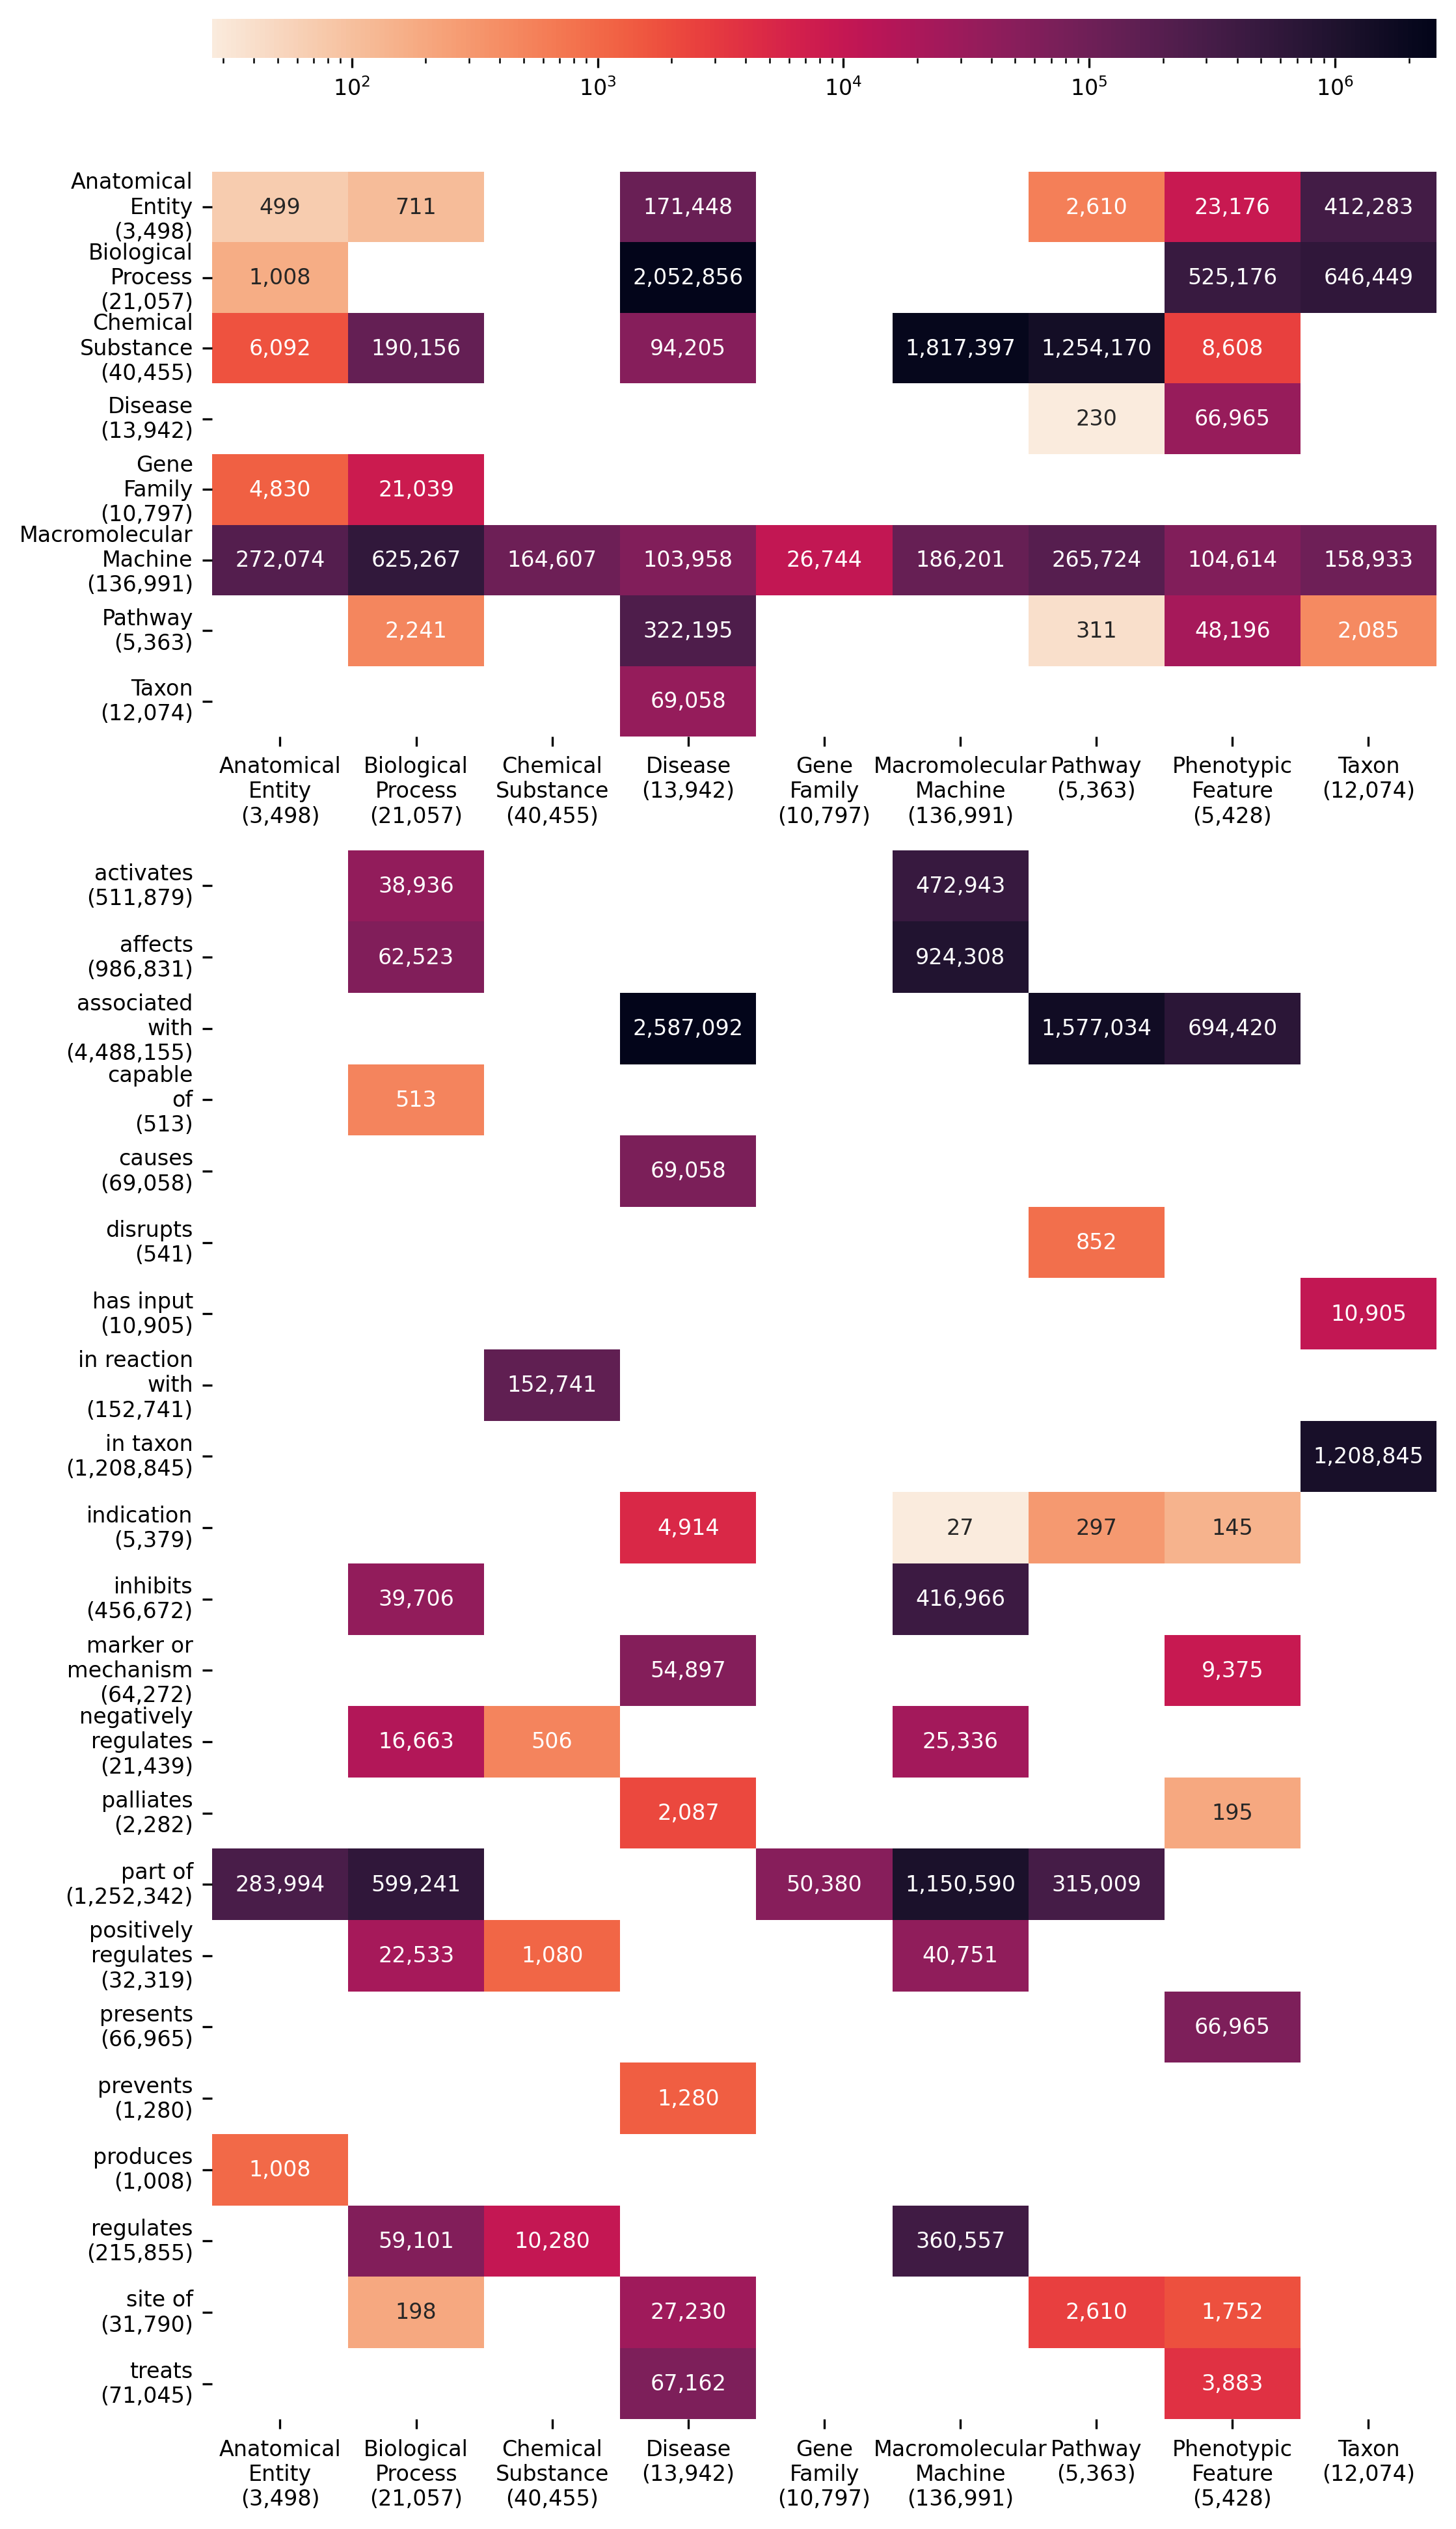

In [81]:
# color bar in log
cmap = sns.cm.rocket_r

fig, (ax0, ax1, ax2) = plt.subplots(
    3,
    1,
    gridspec_kw={
        "height_ratios": [0.025, 0.36, 1],
    },
)

# specify min and max on legend
vmin = min(
    nn_graph.fillna(0).values.min(),
    nr_graph.fillna(0).values.min(),
)
vmax = max(
    nn_graph.fillna(0).values.max(),
    nr_graph.fillna(0).values.max(),
)


# legend as a seperate entity. Coloring is in log scale.
ax0 = fig.colorbar(
    sns.heatmap(
        nr_graph,
        cbar=False,
        norm=LogNorm(),
        vmin=vmin,
        vmax=vmax,
        cmap = cmap
    ).get_children()[0],
    cax=ax0,
    orientation="horizontal",
)
ax0.outline.set_visible(False)

# heatmap 1.
sns.heatmap(
    nn_graph,
    annot=nn_graph,
    ax=ax1,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    fmt=",.0f",
    norm=LogNorm(),
    cmap = cmap
)

ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=0,
)

# heatmap 2. First plot the color in log scale, and values in regular scale
sns.heatmap(
    nr_graph,
    annot=nr_graph,
    ax=ax2,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    fmt=",.0f",
    norm=LogNorm(),
    cmap = cmap
)
# ax2.tick_params(bottom=False)

ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=0,
)

ax1.set_ylabel("")
ax2.set_ylabel("")

plt.tight_layout()
plt.savefig("Heatmap_Edge_Count.png", facecolor="white", edgecolor="none")
plt.show()

In [56]:
plt.rcParams.update(
    {
        "font.size": 8,
        "figure.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "figure.figsize": (7.5, 13),
    }
)

## Generate Testing and Validation Cross Validation Plot

In [102]:
trans_tail_test_mrr = [0.095119, 0.078894, 0.107832, 0.088304, 0.047643]
trans_tail_test_hit1 = [0.005576, 0.003717, 0.000000, 0.005576, 0.001859]
trans_tail_test_hit3 = [0.135688, 0.105948, 0.148699, 0.109665, 0.053903]
trans_tail_test_hit10 = [0.254647, 0.206320, 0.288104, 0.258364, 0.133829]

trans_tail_valid_mrr = [0.094949, 0.140036, 0.091145, 0.070407, 0.132918]
trans_tail_valid_hit1 = [0.007435, 0.014870, 0.003717, 0.007435, 0.000000]
trans_tail_valid_hit3 = [0.137546, 0.213755, 0.109665, 0.079926, 0.154562]
trans_tail_valid_hit10 = [0.249071, 0.382900, 0.243494, 0.185874, 0.411546]

dist_tail_test_mrr = [0.030084, 0.041633, 0.040390, 0.048253, 0.018943]
dist_tail_test_hit1 = [0.005576, 0.018587, 0.011152, 0.020446, 0.003717]
dist_tail_test_hit3 = [0.029740, 0.039033, 0.031599, 0.040892, 0.011152]
dist_tail_test_hit10 = [0.076208, 0.081784, 0.096654, 0.102230, 0.039033]

dist_tail_valid_mrr = [0.029542, 0.050982, 0.054359, 0.039813, 0.068145]
dist_tail_valid_hit1 = [0.003717, 0.007435, 0.020446, 0.018587, 0.020484]
dist_tail_valid_hit3 = [0.027881, 0.040892, 0.044610, 0.031599, 0.074488]
dist_tail_valid_hit10 = [0.063197, 0.146840, 0.111524, 0.074349, 0.143389]

rota_tail_test_mrr = [0.065143, 0.082707, 0.110069, 0.096602, 0.028786]
rota_tail_test_hit1 = [0.031599, 0.042751, 0.066914, 0.068773, 0.007435]
rota_tail_test_hit3 = [0.061338, 0.096654, 0.117100, 0.098513, 0.020446]
rota_tail_test_hit10 = [0.131970, 0.157993, 0.121549, 0.137546, 0.076208]

rota_tail_valid_mrr = [0.087370, 0.143339, 0.105684, 0.063708, 0.187225]
rota_tail_valid_hit1 = [0.046468, 0.091078, 0.070632, 0.039033, 0.113594]
rota_tail_valid_hit3 = [0.089219, 0.146840, 0.111524, 0.061338, 0.217877]
rota_tail_valid_hit10 = [0.161710, 0.250929, 0.180297, 0.102230, 0.320298]

comp_tail_test_mrr = [0.053635, 0.048092, 0.054179, 0.048746, 0.039603]
comp_tail_test_hit1 = [0.020446, 0.016729, 0.016729, 0.014870, 0.020446]
comp_tail_test_hit3 = [0.050186, 0.040892, 0.040892, 0.042751, 0.033457]
comp_tail_test_hit10 = [0.115242, 0.100372, 0.130112, 0.113383, 0.066914]

comp_tail_valid_mrr = [0.053949, 0.066982, 0.083509, 0.048572, 0.121549]
comp_tail_valid_hit1 = [0.013011, 0.024164, 0.031599, 0.016729, 0.048417]
comp_tail_valid_hit3 = [0.053903, 0.061338, 0.079926, 0.048327, 0.137803]
comp_tail_valid_hit10 = [0.120818, 0.154275, 0.193309, 0.094796, 0.251397]

cbr_tail_test_mrr = [0.013017, 0.013027, 0.01498783, 0.01287786, 0.014616]
cbr_tail_test_hits1 = [0.003724, 0.00372439, 0.005587, 0.00372439, 0.005587]
cbr_tail_test_hits3 = [0.013035538, 0.00744879, 0.01117318, 0.009311, 0.01303538]
cbr_tail_test_hits10 = [0.024209, 0.027933, 0.02793296, 0.026071, 0.024209]

cbr_tail_valid_mrr = [0.014351, 0.016217, 0.01318951, 0.01499313, 0.013211]
cbr_tail_valid_hits1 = [0.00558659, 0.007449, 0.00372439, 0.005587, 0.00372439]
cbr_tail_valid_hits3 = [0.009311, 0.013035, 0.009311, 0.009311, 0.009311]
cbr_tail_valid_hits10 = [0.027933, 0.024209, 0.029795, 0.027933, 0.026071]

pcbr_tail_test_mrr = [0.13451687, 0.09624605, 0.02402062, 0.08113121, 0.149789]
pcbr_tail_test_hits1 = [0.085502, 0.06987952, 0.01022305, 0.05855019, 0.09259259]
pcbr_tail_test_hits3 = [0.16635688, 0.09156627, 0.02230483, 0.076208, 0.14814815]
pcbr_tail_test_hits10 = [0.23234201, 0.16144578, 0.03996283, 0.135688, 0.24074074]

pcbr_tail_valid_mrr = [0.093097, 0.146617, 0.07248127, 0.08797963, 0.16621047]
pcbr_tail_valid_hits1 = [0.04832714, 0.09758364, 0.05111524, 0.06877323, 0.10707635]
pcbr_tail_valid_hits3 = [0.111524, 0.171933, 0.074349, 0.090149, 0.1716322]
pcbr_tail_valid_hits10 = [0.18494424, 0.228625, 0.125465, 0.12453532, 0.27932961]


rep_tail_test_mrr = [0.080982, 0.077318, 0.082500, 0.151603, 0.107558]
rep_tail_test_hits1 = [0.053232, 0.031835, 0.026616, 0.081301, 0.033233]
rep_tail_test_hits3 = [0.076046, 0.082397, 0.106464, 0.164634, 0.114804]
rep_tail_test_hits10 = [0.127376, 0.149813, 0.169202, 0.288618, 0.271903]

rep_tail_valid_mrr = [0.078730, 0.092136, 0.081015, 0.167201, 0.103483]
rep_tail_valid_hits1 = [0.041825, 0.054307, 0.026616, 0.103659, 0.030211]
rep_tail_valid_hits3 = [0.085551, 0.093633, 0.102662, 0.168699, 0.117825]
rep_tail_valid_hits10 = [0.142586, 0.155431, 0.167300, 0.302846, 0.256798]

# Hyperparameter Optimized results. Unfair when the others did not hpo for every slice of cross validation
# rep_tail_test_mrr = [0.085078, 0.079490, 0.082298, 0.147090, 0.106330]
# rep_tail_test_hits1 = [0.055133, 0.035581, 0.028517, 0.075203, 0.033233]
# rep_tail_test_hits3 = [0.081749, 0.088015, 0.104563, 0.158537, 0.114804]
# rep_tail_test_hits10 = [0.142586, 0.146067, 0.165399, 0.284553, 0.268882]

# rep_tail_valid_mrr = [0.090335, 0.109516, 0.066167, 0.145360, 0.200522]
# rep_tail_valid_hits1 = [0.030361, 0.028571, 0.035714, 0.092105, 0.124760]
# rep_tail_valid_hits3 = [0.127135, 0.152381, 0.069549, 0.142105, 0.211132]
# rep_tail_valid_hits10 = [0.168880, 0.253333, 0.118421, 0.257895, 0.345489]

In [103]:
test_transe_df = pd.DataFrame(
    {
        "mrr": trans_tail_test_mrr,
        "hits@1": trans_tail_test_hit1,
        "hits@3": trans_tail_test_hit3,
        "hits@10": trans_tail_test_hit10,
    }
)
valid_transe_df = pd.DataFrame(
    {
        "mrr": trans_tail_valid_mrr,
        "hits@1": trans_tail_valid_hit1,
        "hits@3": trans_tail_valid_hit3,
        "hits@10": trans_tail_valid_hit10,
    }
)
test_dist_df = pd.DataFrame(
    {
        "mrr": dist_tail_test_mrr,
        "hits@1": dist_tail_test_hit1,
        "hits@3": dist_tail_test_hit3,
        "hits@10": dist_tail_test_hit10,
    }
)
valid_dist_df = pd.DataFrame(
    {
        "mrr": dist_tail_valid_mrr,
        "hits@1": dist_tail_valid_hit1,
        "hits@3": dist_tail_valid_hit3,
        "hits@10": dist_tail_valid_hit10,
    }
)
test_rota_df = pd.DataFrame(
    {
        "mrr": rota_tail_test_mrr,
        "hits@1": rota_tail_test_hit1,
        "hits@3": rota_tail_test_hit3,
        "hits@10": rota_tail_test_hit10,
    }
)
valid_rota_df = pd.DataFrame(
    {
        "mrr": rota_tail_valid_mrr,
        "hits@1": rota_tail_valid_hit1,
        "hits@3": rota_tail_valid_hit3,
        "hits@10": rota_tail_valid_hit10,
    }
)
test_comp_df = pd.DataFrame(
    {
        "mrr": comp_tail_test_mrr,
        "hits@1": comp_tail_test_hit1,
        "hits@3": comp_tail_test_hit3,
        "hits@10": comp_tail_test_hit10,
    }
)
valid_comp_df = pd.DataFrame(
    {
        "mrr": comp_tail_valid_mrr,
        "hits@1": comp_tail_valid_hit1,
        "hits@3": comp_tail_valid_hit3,
        "hits@10": comp_tail_valid_hit10,
    }
)

test_pcbr_df = pd.DataFrame(
    {
        "mrr": pcbr_tail_test_mrr,
        "hits@1": pcbr_tail_test_hits1,
        "hits@3": pcbr_tail_test_hits3,
        "hits@10": pcbr_tail_test_hits10,
    }
)

valid_pcbr_df = pd.DataFrame(
    {
        "mrr": pcbr_tail_valid_mrr,
        "hits@1": pcbr_tail_valid_hits1,
        "hits@3": pcbr_tail_valid_hits3,
        "hits@10": pcbr_tail_valid_hits10,
    }
)

test_cbr_df = pd.DataFrame(
    {
        "mrr": cbr_tail_test_mrr,
        "hits@1": cbr_tail_test_hits1,
        "hits@3": cbr_tail_test_hits3,
        "hits@10": cbr_tail_test_hits10,
    }
)

valid_cbr_df = pd.DataFrame(
    {
        "mrr": cbr_tail_valid_mrr,
        "hits@1": cbr_tail_valid_hits1,
        "hits@3": cbr_tail_valid_hits3,
        "hits@10": cbr_tail_valid_hits10,
    }
)

test_rep_df = pd.DataFrame(
    {
        "mrr": rep_tail_test_mrr,
        "hits@1": rep_tail_test_hits1,
        "hits@3": rep_tail_test_hits3,
        "hits@10": rep_tail_test_hits10,
    }
)

valid_rep_df = pd.DataFrame(
    {
        "mrr": rep_tail_valid_mrr,
        "hits@1": rep_tail_valid_hits1,
        "hits@3": rep_tail_valid_hits3,
        "hits@10": rep_tail_valid_hits10,
    }
)


melt_ls = []
for i in [
    "test_transe_df",
    "valid_transe_df",
    "test_dist_df",
    "valid_dist_df",
    "test_rota_df",
    "valid_rota_df",
    "test_comp_df",
    "valid_comp_df",
    "test_pcbr_df",
    "valid_pcbr_df",
    "test_cbr_df",
    "valid_cbr_df",
    "test_rep_df",
    "valid_rep_df"
]:
    str_name = i
    j = eval(i).melt()
    j["subset"] = str_name.split("_")[0]
    j["algo"] = str_name.split("_")[1]
    melt_ls.append(j)

In [104]:
melted_df = pd.concat(melt_ls)
melted_df.shape

(280, 4)

In [105]:
melted_df.head()

,variable,value,subset,algo
0,mrr,0.095119,test,transe
1,mrr,0.078894,test,transe
2,mrr,0.107832,test,transe
3,mrr,0.088304,test,transe
4,mrr,0.047643,test,transe


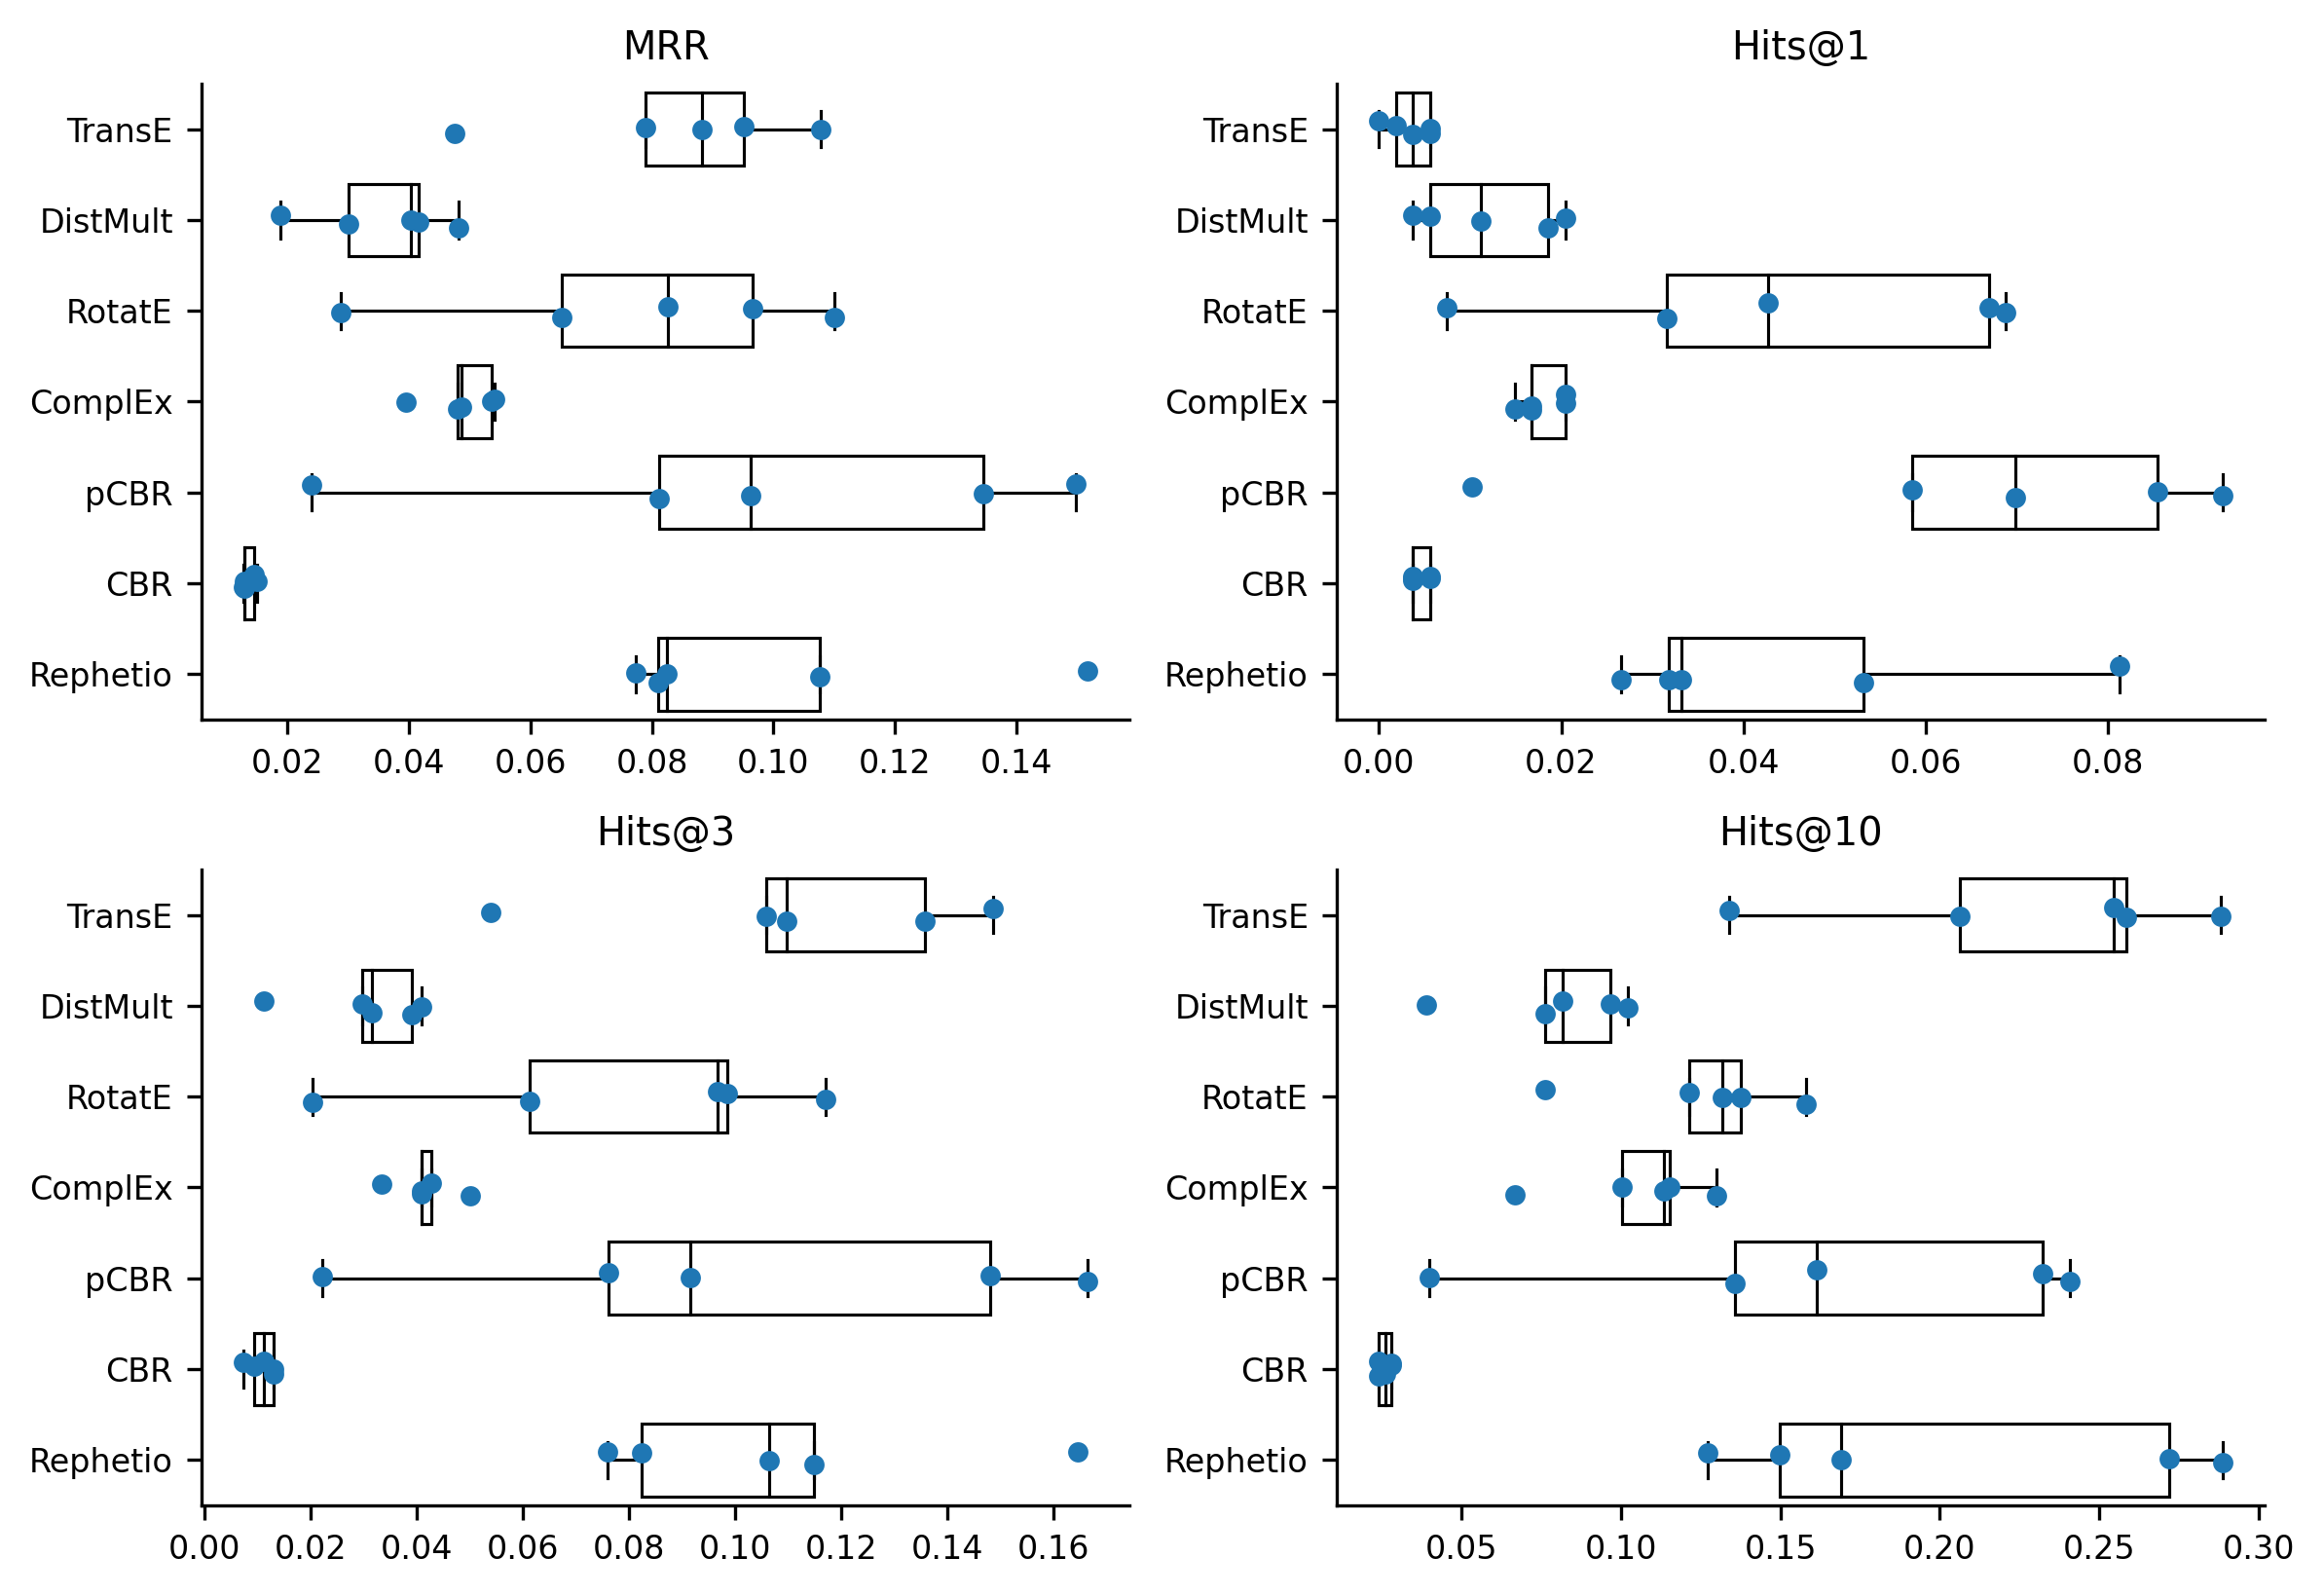

In [106]:
# color bar in log
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2,
    nrows=2,
    gridspec_kw={"height_ratios": [1, 1], "width_ratios": [1, 1]},
    figsize=(8, 5.5),
)

# 'boxprops':{'facecolor':'none', 'edgecolor':'red'},
#     'medianprops':{'color':'green'},
#     'whiskerprops':{'color':'blue'},
#     'capprops':{'color':'yellow'}

sns.boxplot(
    data=melted_df.query('subset=="test" and variable=="mrr"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax0,
)
sns.stripplot(
    data=melted_df.query('subset=="test" and variable=="mrr"'),
    y="algo",
    x="value",
    dodge=True,
    ax=ax0,
)

sns.boxplot(
    data=melted_df.query('subset=="test" and variable=="hits@1"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax1,
)
sns.stripplot(
    data=melted_df.query('subset=="test" and variable=="hits@1"'),
    y="algo",
    x="value",
    dodge=True,
    ax=ax1,
)

sns.boxplot(
    data=melted_df.query('subset=="test" and variable=="hits@3"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax2,
)
sns.stripplot(
    data=melted_df.query('subset=="test" and variable=="hits@3"'),
    y="algo",
    x="value",
    dodge=True,
    ax=ax2,
)

sns.boxplot(
    data=melted_df.query('subset=="test" and variable=="hits@10"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax3,
)
sns.stripplot(
    data=melted_df.query('subset=="test" and variable=="hits@10"'),
    y="algo",
    x="value",
    dodge=True,
    ax=ax3,
)

# remove x and yaxis labels
for i in [ax0, ax1, ax2, ax3]:
    i.set_ylabel("")
    i.set_xlabel("")
    # set y-axis labels
    i.set_yticklabels(["TransE", "DistMult", "RotatE", "ComplEx", "pCBR", "CBR","Rephetio"])

# set titles
ax0.set_title("MRR")
ax1.set_title("Hits@1")
ax2.set_title("Hits@3")
ax3.set_title("Hits@10")

plt.tight_layout()
# plt.savefig("XValidation_BP.png", facecolor="white", edgecolor="none")
plt.show()

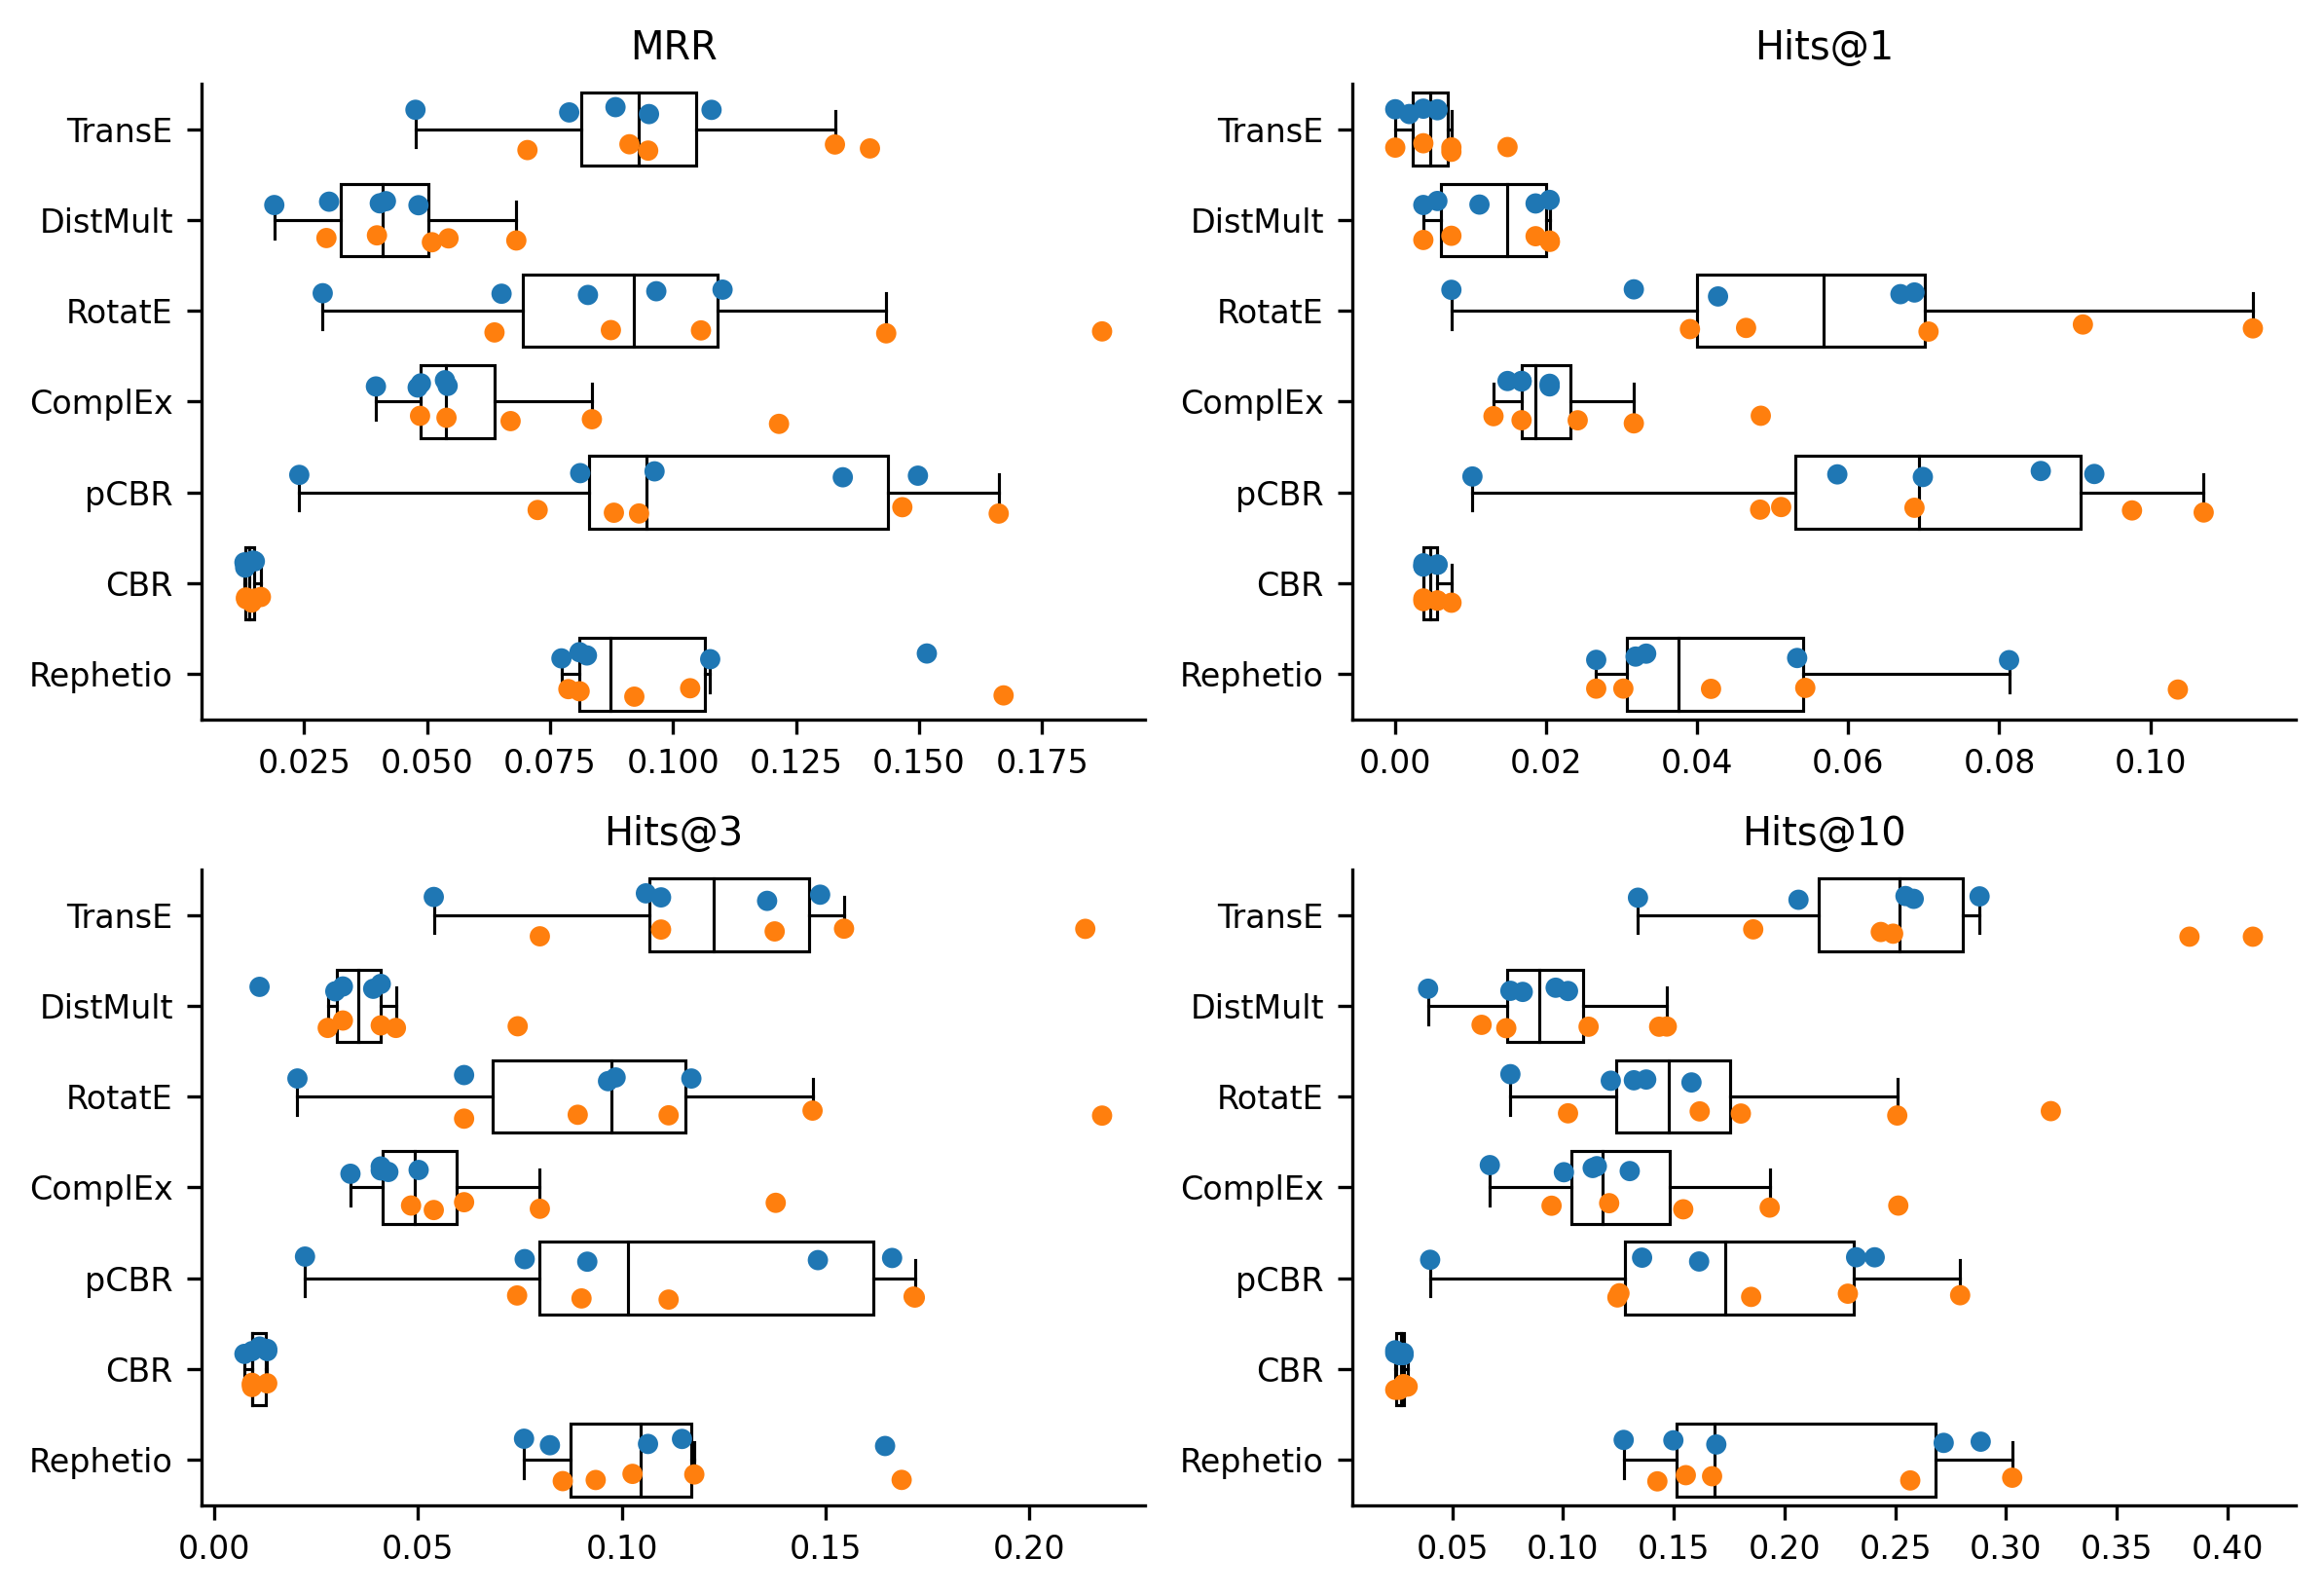

In [107]:
# Test and Validation Results
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2,
    nrows=2,
    gridspec_kw={"height_ratios": [1, 1], "width_ratios": [1, 1]},
    figsize=(8, 5.5),
)

sns.boxplot(
    data=melted_df.query('variable=="mrr"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax0,
)
sns.stripplot(
    data=melted_df.query('variable=="mrr"'),
    y="algo",
    x="value",
    hue="subset",
    legend=False,
    dodge=True,
    ax=ax0,
)

sns.boxplot(
    data=melted_df.query('variable=="hits@1"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax1,
)
sns.stripplot(
    data=melted_df.query('variable=="hits@1"'),
    y="algo",
    x="value",
    hue="subset",
    legend=False,
    dodge=True,
    ax=ax1,
)

sns.boxplot(
    data=melted_df.query('variable=="hits@3"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax2,
)
sns.stripplot(
    data=melted_df.query('variable=="hits@3"'),
    y="algo",
    x="value",
    hue="subset",
    legend=False,
    dodge=True,
    ax=ax2,
)

sns.boxplot(
    data=melted_df.query('variable=="hits@10"'),
    y="algo",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax3,
)
sns.stripplot(
    data=melted_df.query('variable=="hits@10"'),
    y="algo",
    x="value",
    hue="subset",
    legend=False,
    dodge=True,
    ax=ax3,
)

# remove x and yaxis labels
for i in [ax0, ax1, ax2, ax3]:
    i.set_ylabel("")
    i.set_xlabel("")
    # set y-axis labels
    i.set_yticklabels(["TransE", "DistMult", "RotatE", "ComplEx", "pCBR", "CBR", "Rephetio"])

# set titles
ax0.set_title("MRR")
ax1.set_title("Hits@1")
ax2.set_title("Hits@3")
ax3.set_title("Hits@10")

plt.tight_layout()
plt.savefig("XValidation_BP2.png", facecolor="white", edgecolor="none")
plt.show()

In [108]:
melted_df.head()

,variable,value,subset,algo
0,mrr,0.095119,test,transe
1,mrr,0.078894,test,transe
2,mrr,0.107832,test,transe
3,mrr,0.088304,test,transe
4,mrr,0.047643,test,transe


In [109]:
set(melted_df["algo"])

{'cbr', 'comp', 'dist', 'pcbr', 'rep', 'rota', 'transe'}

In [110]:
# mean cross validation statistics

transe_mean_dict = {
    "mrr": melted_df.query('algo=="transe" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="transe" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="transe" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="transe" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
dist_mean_dict = {
    "mrr": melted_df.query('algo=="dist" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="dist" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="dist" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="dist" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
comp_mean_dict = {
    "mrr": melted_df.query('algo=="comp" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="comp" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="comp" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="comp" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
rota_mean_dict = {
    "mrr": melted_df.query('algo=="rota" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="rota" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="rota" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="rota" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
pcbr_mean_dict = {
    "mrr": melted_df.query('algo=="pcbr" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="pcbr" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="pcbr" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="pcbr" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
cbr_mean_dict = {
    "mrr": melted_df.query('algo=="cbr" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="cbr" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="cbr" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="cbr" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}
rep_mean_dict = {
    "mrr": melted_df.query('algo=="rep" and variable =="mrr"')
    .describe()
    .loc["mean"][0],
    "hits1": melted_df.query('algo=="rep" and variable =="hits@1"')
    .describe()
    .loc["mean"][0],
    "hits3": melted_df.query('algo=="rep" and variable =="hits@3"')
    .describe()
    .loc["mean"][0],
    "hits10": melted_df.query('algo=="rep" and variable =="hits@10"')
    .describe()
    .loc["mean"][0],
}

mrr_ls, hits1_ls, hits3_ls, hits10_ls = list(), list(), list(), list()
for i in [
    transe_mean_dict,
    dist_mean_dict,
    comp_mean_dict,
    rota_mean_dict,
    pcbr_mean_dict,
    cbr_mean_dict,
    rep_mean_dict
]:
    mrr_ls.append(i["mrr"])
    hits1_ls.append(i["hits1"])
    hits3_ls.append(i["hits3"])
    hits10_ls.append(i["hits10"])

pd.DataFrame(
    {
        "algo": ["TransE", "DistMult", "ComplEx", "RotatE", "pCBR", "CBR","Rephetio"],
        "mrr": mrr_ls,
        "hits@1": hits1_ls,
        "hits@3": hits3_ls,
        "hits@10": hits10_ls,
    }
)

,algo,mrr,hits@1,hits@3,hits@10
0,TransE,0.094725,0.005018,0.124936,0.261415
1,DistMult,0.042214,0.013015,0.037189,0.093521
2,ComplEx,0.061882,0.022314,0.058947,0.134062
3,RotatE,0.097063,0.057828,0.102085,0.164073
4,pCBR,0.105209,0.068962,0.112417,0.175308
5,CBR,0.014049,0.004842,0.010428,0.026630
6,Rephetio,0.102253,0.048283,0.111272,0.203187


In [111]:
# median cross validation statistics

transe_med_dict = {
    "mrr": melted_df.query('algo=="transe" and variable =="mrr"')
    .describe()
    .loc["50%"][0],
    "hits1": melted_df.query('algo=="transe" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="transe" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="transe" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
dist_med_dict = {
    "mrr": melted_df.query('algo=="dist" and variable =="mrr"')
    .describe()
    .loc["50%"][0],
    "hits1": melted_df.query('algo=="dist" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="dist" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="dist" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
comp_med_dict = {
    "mrr": melted_df.query('algo=="comp" and variable =="mrr"')
    .describe()
    .loc["50%"][0],
    "hits1": melted_df.query('algo=="comp" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="comp" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="comp" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
rota_med_dict = {
    "mrr": melted_df.query('algo=="rota" and variable =="mrr"')
    .describe()
    .loc["50%"][0],
    "hits1": melted_df.query('algo=="rota" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="rota" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="rota" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
pcbr_med_dict = {
    "mrr": melted_df.query('algo=="pcbr" and variable =="mrr"')
    .describe()
    .loc["50%"][0],
    "hits1": melted_df.query('algo=="pcbr" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="pcbr" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="pcbr" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
cbr_med_dict = {
    "mrr": melted_df.query('algo=="cbr" and variable =="mrr"').describe().loc["50%"][0],
    "hits1": melted_df.query('algo=="cbr" and variable =="hits@1"')
    .describe()
    .loc["50%"][0],
    "hits3": melted_df.query('algo=="cbr" and variable =="hits@3"')
    .describe()
    .loc["50%"][0],
    "hits10": melted_df.query('algo=="cbr" and variable =="hits@10"')
    .describe()
    .loc["50%"][0],
}
rep_med_dict = {'mrr':melted_df.query('algo=="rep" and variable =="mrr"').describe().loc['50%'][0],
                    'hits1':melted_df.query('algo=="rep" and variable =="hits@1"').describe().loc['50%'][0],
                    'hits3':melted_df.query('algo=="rep" and variable =="hits@3"').describe().loc['50%'][0],
                    'hits10':melted_df.query('algo=="rep" and variable =="hits@10"').describe().loc['50%'][0]}

mrr_ls, hits1_ls, hits3_ls, hits10_ls = list(), list(), list(), list()
for i in [
    transe_med_dict,
    dist_med_dict,
    comp_med_dict,
    rota_med_dict,
    pcbr_med_dict,
    cbr_med_dict,
    rep_med_dict
]:
    mrr_ls.append(i["mrr"])
    hits1_ls.append(i["hits1"])
    hits3_ls.append(i["hits3"])
    hits10_ls.append(i["hits10"])

pd.DataFrame(
    {
        "algo": ["TransE", "DistMult", "ComplEx", "RotatE", "pCBR", "CBR","Rephetio"],
        "mrr": mrr_ls,
        "hits@1": hits1_ls,
        "hits@3": hits3_ls,
        "hits@10": hits10_ls,
    }
)

,algo,mrr,hits@1,hits@3,hits@10
0,TransE,0.093047,0.004646,0.122676,0.251859
1,DistMult,0.041012,0.014870,0.035316,0.089219
2,ComplEx,0.053792,0.018587,0.049257,0.118030
3,RotatE,0.091986,0.056691,0.097584,0.147769
4,pCBR,0.094672,0.069326,0.101545,0.173195
5,CBR,0.013781,0.004655,0.009311,0.027002
6,Rephetio,0.087318,0.037529,0.104563,0.168251


In [112]:
melted_df.describe().loc["50%"]

value    0.070143
Name: 50%, dtype: float64

In [113]:
test_transe_df

,mrr,hits@1,hits@3,hits@10
0,0.095119,0.005576,0.135688,0.254647
1,0.078894,0.003717,0.105948,0.206320
2,0.107832,0.000000,0.148699,0.288104
3,0.088304,0.005576,0.109665,0.258364
4,0.047643,0.001859,0.053903,0.133829


In [114]:
valid_transe_df

,mrr,hits@1,hits@3,hits@10
0,0.094949,0.007435,0.137546,0.249071
1,0.140036,0.014870,0.213755,0.382900
2,0.091145,0.003717,0.109665,0.243494
3,0.070407,0.007435,0.079926,0.185874
4,0.132918,0.000000,0.154562,0.411546


In [115]:
transe_df = pd.DataFrame()
dist_df = pd.DataFrame()
rota_df = pd.DataFrame()
comp_df = pd.DataFrame()

transe_df["mrr"] = (test_transe_df["mrr"] + valid_transe_df["mrr"]) / 2
transe_df["hits@1"] = (test_transe_df["hits@1"] + valid_transe_df["hits@1"]) / 2
transe_df["hits@3"] = (test_transe_df["hits@3"] + valid_transe_df["hits@3"]) / 2
transe_df["hits@10"] = (test_transe_df["hits@10"] + valid_transe_df["hits@10"]) / 2

dist_df["mrr"] = (test_dist_df["mrr"] + valid_dist_df["mrr"]) / 2
dist_df["hits@1"] = (test_dist_df["hits@1"] + valid_dist_df["hits@1"]) / 2
dist_df["hits@3"] = (test_dist_df["hits@3"] + valid_dist_df["hits@3"]) / 2
dist_df["hits@10"] = (test_dist_df["hits@10"] + valid_dist_df["hits@10"]) / 2

rota_df["mrr"] = (test_rota_df["mrr"] + valid_rota_df["mrr"]) / 2
rota_df["hits@1"] = (test_rota_df["hits@1"] + valid_rota_df["hits@1"]) / 2
rota_df["hits@3"] = (test_rota_df["hits@3"] + valid_rota_df["hits@3"]) / 2
rota_df["hits@10"] = (test_rota_df["hits@10"] + valid_rota_df["hits@10"]) / 2

comp_df["mrr"] = (test_transe_df["mrr"] + valid_transe_df["mrr"]) / 2
comp_df["hits@1"] = (test_comp_df["hits@1"] + valid_comp_df["hits@1"]) / 2
comp_df["hits@3"] = (test_comp_df["hits@3"] + valid_comp_df["hits@3"]) / 2
comp_df["hits@10"] = (test_comp_df["hits@10"] + valid_comp_df["hits@10"]) / 2

In [116]:
# label
transe_df["name"] = "TransE"
dist_df["name"] = "DistMult"
rota_df["name"] = "RotatE"
comp_df["name"] = "ComplEx"

In [117]:
a_df = pd.concat([transe_df, dist_df, rota_df, comp_df])

In [118]:
a_df_melt = a_df.melt(id_vars=["name"])
a_df_melt

,name,variable,value
0,TransE,mrr,0.095034
1,TransE,mrr,0.109465
2,TransE,mrr,0.099489
3,TransE,mrr,0.079355
4,TransE,mrr,0.090280
...,...,...,...
75,ComplEx,hits@10,0.118030
76,ComplEx,hits@10,0.127324
77,ComplEx,hits@10,0.161711
78,ComplEx,hits@10,0.104090


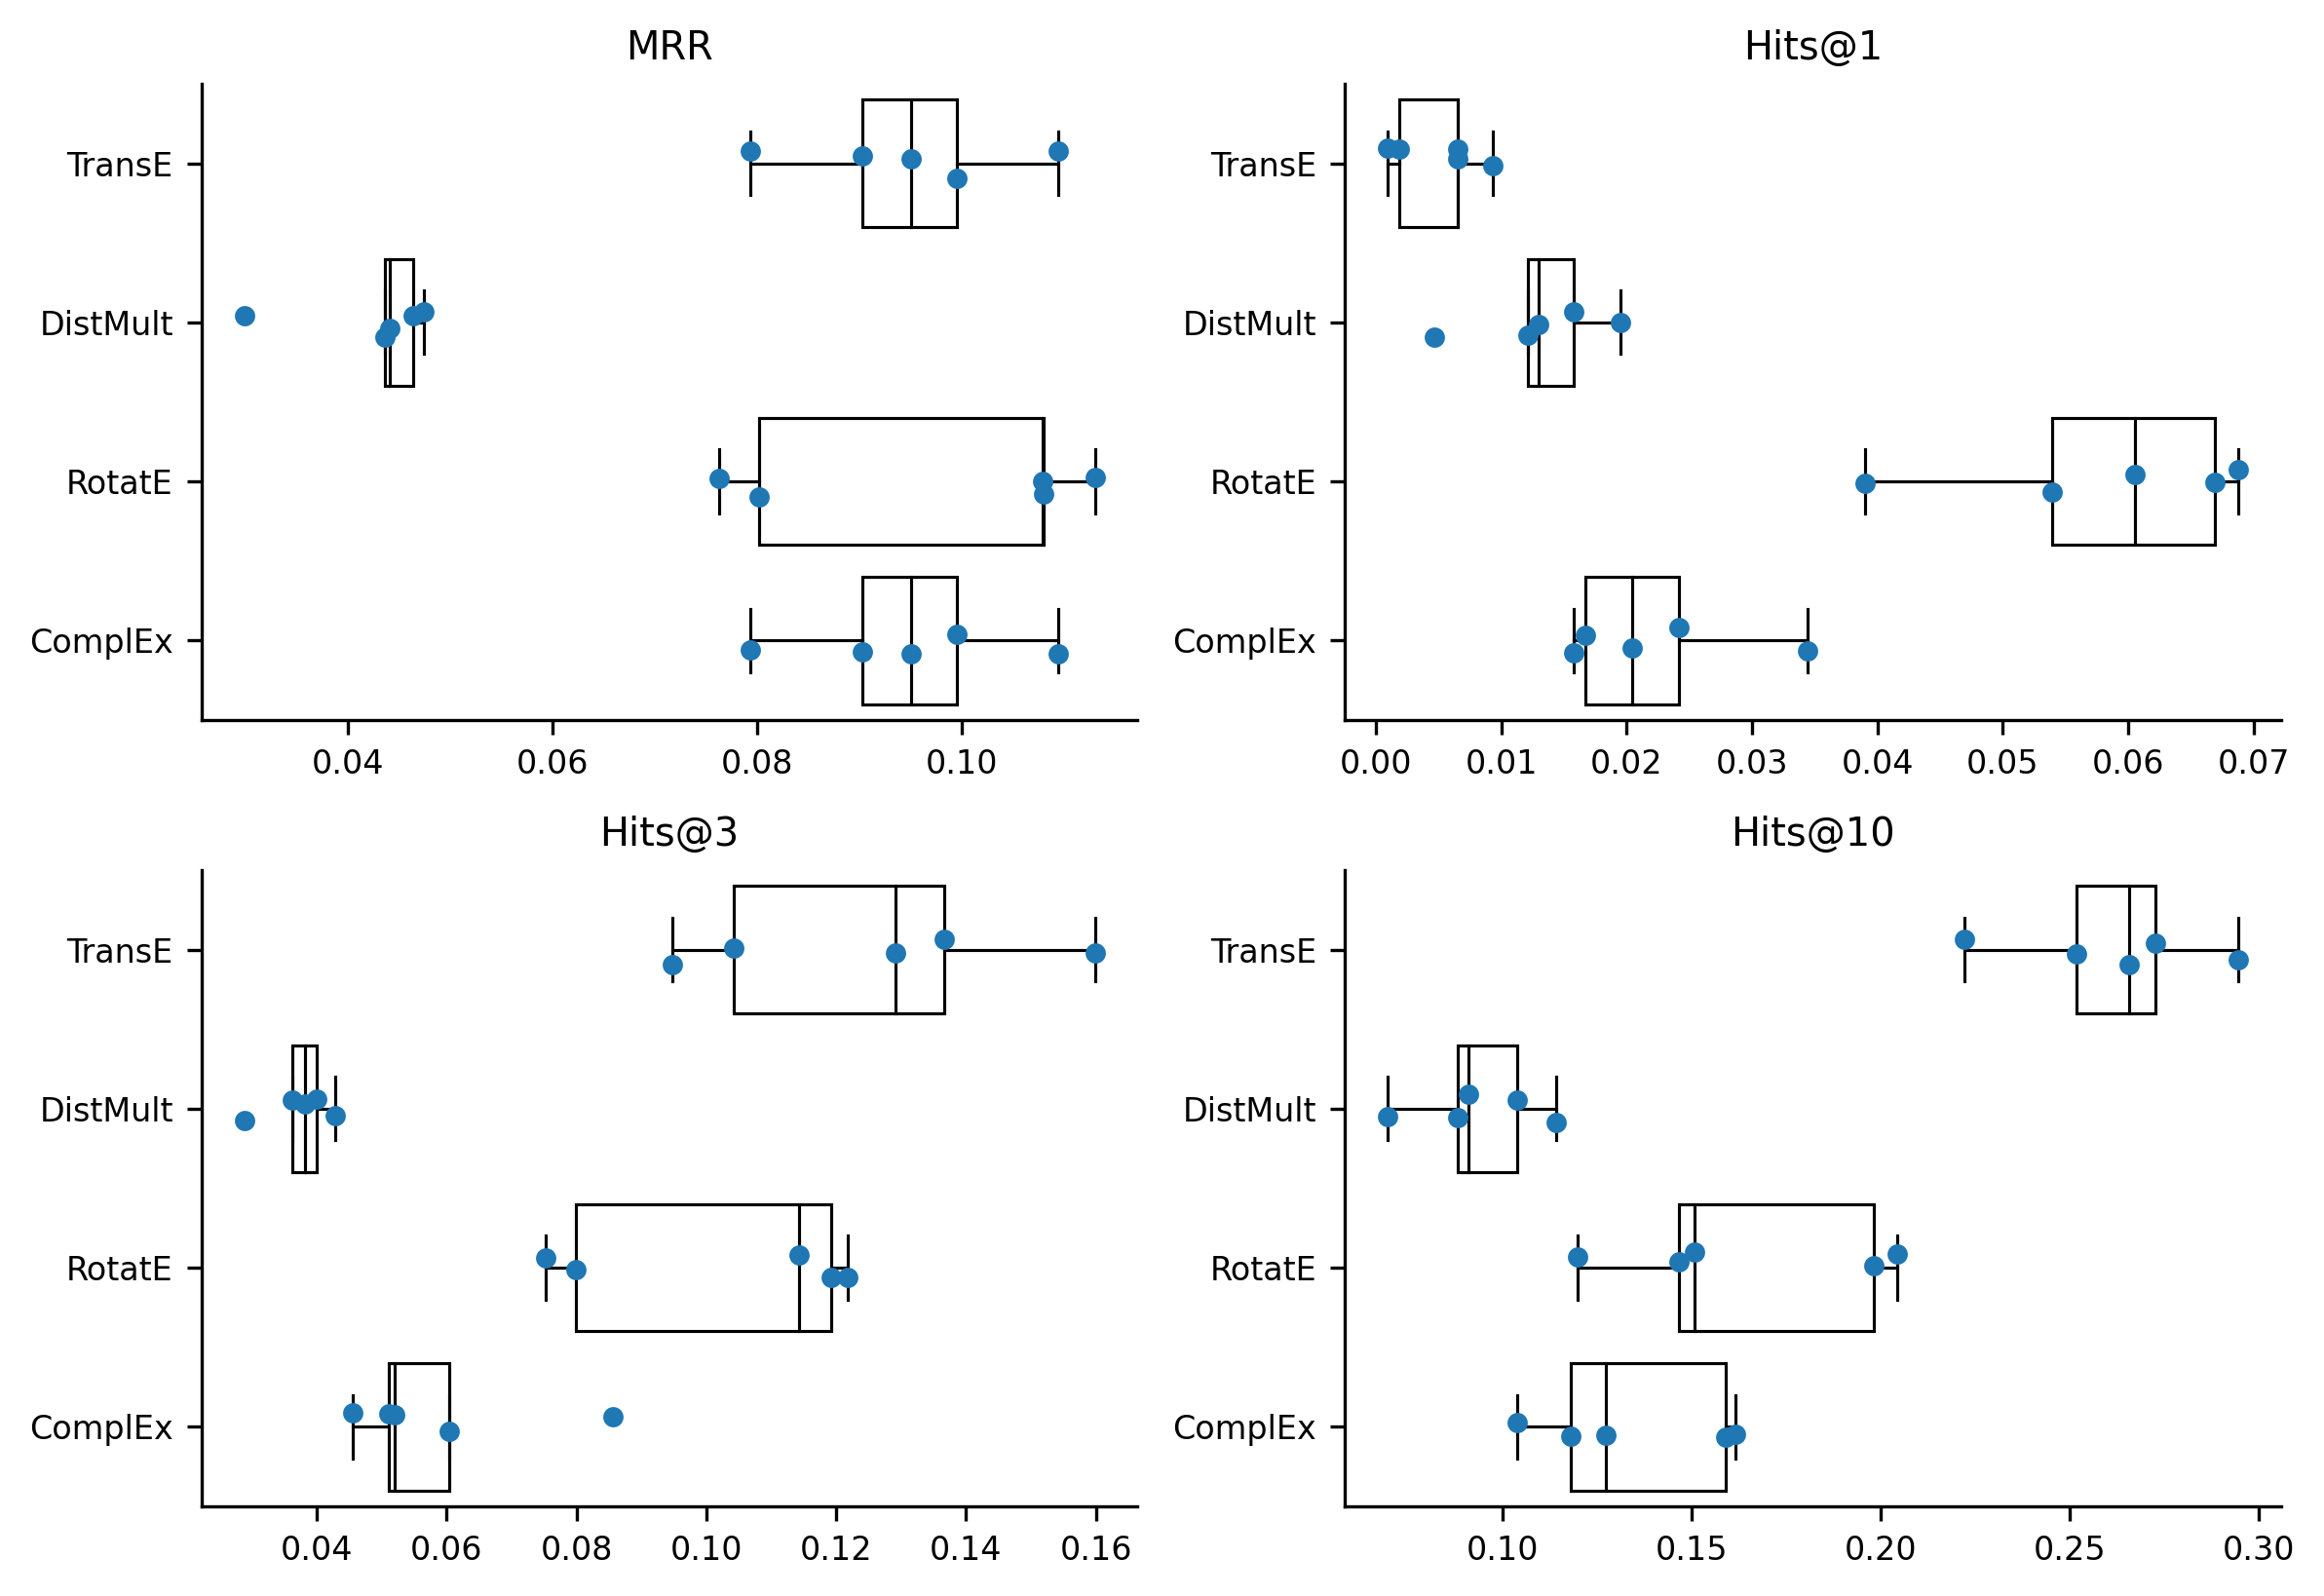

In [119]:
# average boxplots vals

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2,
    nrows=2,
    gridspec_kw={"height_ratios": [1, 1], "width_ratios": [1, 1]},
    figsize=(8, 5.5),
)

sns.boxplot(
    data=a_df_melt.query('variable=="mrr"'),
    y="name",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax0,
)
sns.stripplot(
    data=a_df_melt.query('variable=="mrr"'), y="name", x="value", dodge=True, ax=ax0
)

sns.boxplot(
    data=a_df_melt.query('variable=="hits@1"'),
    y="name",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax1,
)
sns.stripplot(
    data=a_df_melt.query('variable=="hits@1"'), y="name", x="value", dodge=True, ax=ax1
)

sns.boxplot(
    data=a_df_melt.query('variable=="hits@3"'),
    y="name",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax2,
)
sns.stripplot(
    data=a_df_melt.query('variable=="hits@3"'), y="name", x="value", dodge=True, ax=ax2
)

sns.boxplot(
    data=a_df_melt.query('variable=="hits@10"'),
    y="name",
    x="value",
    showfliers=False,
    linewidth=0.75,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax3,
)
sns.stripplot(
    data=a_df_melt.query('variable=="hits@10"'), y="name", x="value", dodge=True, ax=ax3
)

# remove x and yaxis labels
for i in [ax0, ax1, ax2, ax3]:
    i.set_ylabel("")
    i.set_xlabel("")
    # set y-axis labels
    i.set_yticklabels(["TransE", "DistMult", "RotatE", "ComplEx"])

# set titles
ax0.set_title("MRR")
ax1.set_title("Hits@1")
ax2.set_title("Hits@3")
ax3.set_title("Hits@10")

plt.tight_layout()
# plt.savefig("XValidation_BP2.png", facecolor="white", edgecolor="none")
plt.show()

In [80]:
nodes = pd.read_csv("/home/rogertu/MRN_dataset/nodes_biolink.csv")

/tmp/ipykernel_2665388/1440979420.py:1: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes = pd.read_csv('/home/rogertu/MRN_dataset/nodes_biolink.csv')


In [81]:
nodes.head(2)

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
0,UBERON:0000002,cervix,AnatomicalEntity,MESH:D002584|UBERON:0000002,NaN,NaN,NaN,NaN
1,UBERON:0000004,human nose,AnatomicalEntity,MESH:D009666|UBERON:0000004,NaN,NaN,NaN,NaN


In [83]:
set(nodes.label)

{'AnatomicalEntity',
 'BiologicalProcessOrActivity',
 'ChemicalSubstance',
 'Disease',
 'GeneFamily',
 'MacromolecularMachine',
 'OrganismTaxon',
 'Pathway',
 'PhenotypicFeature'}

In [91]:
set(
    nodes.query('label == "BiologicalProcessOrActivity"')["id"].apply(
        lambda x: x.split(":")[0]
    )
)

{'GO'}